# Elizabeth Daly
# HDip Data Analytics 2020
## Machine Learning & Statistics Project
***

For the module project we must create a web service that uses machine learning to make predictions of wind turbine power output from wind speed values. The web service should respond with predicted power values based on wind speed values sent as HTTP requests. A Dockerfile will be used to build and run the web service in a container. 

The very first thing to do is to import required packages. I do them all here in one place.

In [1]:
# For data frames.
import pandas as pd

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt

#For maths
import math as m

# Might use this.
import seaborn as sns

# For linear regression.
from sklearn import linear_model

# For evaluating model performance.
from sklearn.metrics import mean_squared_error, r2_score

# For generating polynomial features in the data.
from sklearn.preprocessing import PolynomialFeatures

# For splitting data into train / test sets.
from sklearn.model_selection import train_test_split

# For defining a pipeline. NOT USED
# from sklearn.pipeline import Pipeline

# For support vector machine regression.
from sklearn.svm import SVR

# Want to scale the input  for SVR.
from sklearn.preprocessing import StandardScaler

# For neural networks
import tensorflow.keras as kr

# For saving/restoring models using pickle
import joblib

In [2]:
plt.rcParams['figure.figsize'] = (8.0, 6.0) # Make nice big figures

## Data exploration
Reference <span style='color:red'> [1 Geron] </span> suggests a number of steps to follow when beginning a new machine learning project. The very first is to get the data and explore it, so now I'll import the **powerproduction** dataset provided and have a look at it. I'll also keep an intact copy of the original dataset in a dataframe called dforig. 

In [3]:
# File provided as a txt file. I saved it as a csv file.
df = pd.read_csv("data\powerproduction.csv")

# Make a copy of the original dataset in case we need it later.
dforig = df

# Size?
shape = df.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(df.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [4]:
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The raw data contains a column of wind speed values (in increasing order of wind speed) and a column of associated power values. Looks like the first and last 5 lines contain zeros for power. Is this just a fluke? There's probably a reason for it: one can't generate power with low wind speeds and perhaps one can't operate the turbines at very high wind speeds? Check by printing more of the head of file. No units have been provided with the data, so I will assume units of wind speed are (m/s), and those of power are kilowatts (kW), as that's what seems to make sense for these numbers.

In [5]:
df.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
# Look at some quick descriptive statistics of the numeric data.
print(df.describe())

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6.324750    5.288000
50%     12.550500   41.645500
75%     18.775250   93.537000
max     25.000000  113.556000


Look at the distribution of wind speeds. Why? Our assignment in the Programming for Data Analysis module involved looking at the numpy.random package <span style='color:red'> [2 np random]</span>. I learned that, under certain conditions, wind speed has a Rayleigh distribution, which is not symmetrical. I wonder if the samples in our dataset follow a such distribution? The mean and variance of this distribution are calculated from the scale factor: $\mu = \sqrt{\pi / 2} s$ and $\sigma^2 = (4 - \pi)/2 s^2$. This results in $\mu \approx 1.25 s$ and $\sigma^2 \approx 0.43 s$. From the descriptive statistics above we know that the mean wind speed is 12.6 m/s, so the scale factor to use is $s = \mu/1.25 \approx 10$.

Average wind speed is 12.59 m/s


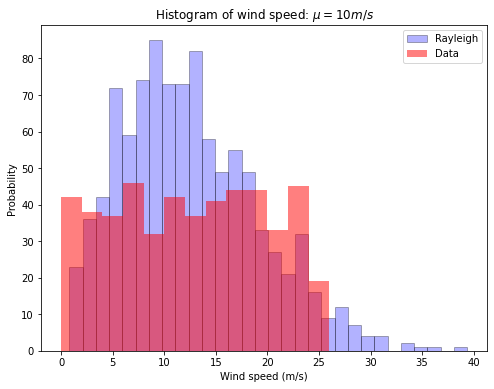

In [7]:
# Wind speeds sampled from a Rayleigh distribution, mean=12.6 m/s
# Default: numpy.random.rayleigh(scale=1.0, size=None)
data = np.random.rayleigh(10, 1000) 
plt.hist(data, bins=30, alpha = 0.3, facecolor='blue', edgecolor='black', label=['Rayleigh'])

bins = np.arange(0, 30, 2) # fixed bin size
plt.hist(df['speed'], bins=bins, alpha=0.5, facecolor='red', label=['Data'])

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Probability')
plt.title('Histogram of wind speed: $\mu=10 m/s$')
plt.legend()
w = df['speed'].mean(axis=0)
print(f'Average wind speed is {w:.2f} m/s')

Well, that was a dead end. Clearly the wind speeds provided do not follow a Rayleigh distribution, rather roughly a uniform distribution.

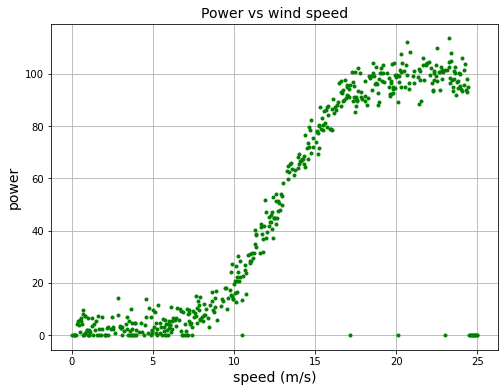

In [8]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(df['speed'], df['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

Clearly there isn't a simple relationship between power and speed. It looks as if little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (10 - 15 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed, but we need to consider a model that works outside of this range also. Apart from the zero power values at the top and bottom (more here) of the dataset, there are very occasional zero values for power above about 10 m/s; to me they just look like anomalies.

### What do we expect?
Is this the curve we should expect? I think so. The theoretical power curve for a turbine is specific to each turbine and site; see Figure 2 in <span style='color:red'> [3 WT curve] </span>. I'll include a screengrab here. On the figure:
- The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 3 m/s.
- The rated output power is achieved at approximately 12 - 13 m/s.
- The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.

<img src="img/P-wind-theory.JPG" height=500 width=500>

How is this theoretical curve calculated? I found some formulae which state that the extractable power from the wind is given by:
$$P = \frac{1}{2} \rho A v^3 C_p$$
where $\rho$ is the density of air, $A$ is the area swept by the turbines, $v$ is the wind speed, and $C_p$ is the power coefficient <span style='color:red'> [4 WT calc] </span>. Looking at this formula I would expect power to depend on $v^3$. However, $C_p$ is not static as it depends on the ratio of blade tip speed to wind speed (called $\lambda$). That function looks like this:

<img src="img/Cp-lambda.JPG">

Average wind speed in data is 12.59 m/s


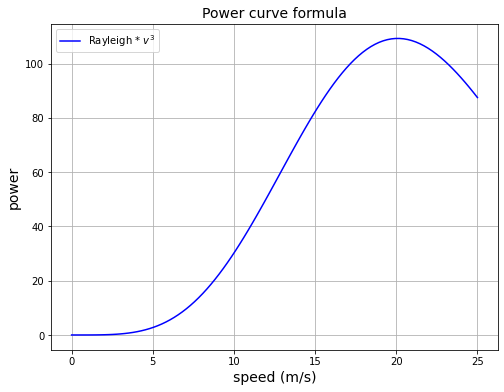

In [9]:
# So I would expect the power curve to be a product of $v^3$ and this bump above. I'll try to model it.
# wind speed
x = np.linspace(0, 25, 100)

# speed ^3
v = np.power(x, 3)

# Try a Rayeigh distribution for the power coefficient, need scale factor sc.
# w = mean wind speed from our dataset above
print(f'Average wind speed in data is {w:.2f} m/s')

sc = w / (m.sqrt((m.pi) / 2)) # mode or scale
ray = lambda s, x: (x / s ** 2) * ( np.exp( (-x **2) / (2 * s **2) )  )

# PLot the product v^3 * Rayleigh and scale it down.
plt.plot(x, 0.5 * ray(sc, x)*v, color='b', label='Rayleigh * $v^3$')
plt.title('Power curve formula', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.legend()
plt.grid()

 So this is starting to look like our data but I feel it would be difficult to model exactly. I'll start with something simpler.

## Data preparation
The next step in a project is to prepare the dataset <span style='color:red'> [1 Geron] </span>. The first thing I'll do is clean it by removing unwanted zeros. The easiest approach would be to remove all rows where power = 0. I don't really want to do that however, because I feel like the zero power values below about 10 m/s are part of the data, while the ones above about 24 m/s represent some sort of a limit of operation. I can't see how a model would be able to abruptly predict power = 0 at the very high end of speed values unless I hard coded it in as a condition, or constrained the allowed input speed values to a range. I might come back to this here, or place a limit on wind speed input values in the front end of the application.
Other steps which could happen now include feature selection and feature scaling. Feature selection is used to drop inputs that provide no useful information; in our case we have only one input (speed) so that step isn't relevant. Feature scaling would be necessary if the scale of an input feature was very big or small compared to other features; again, not relevant here. 

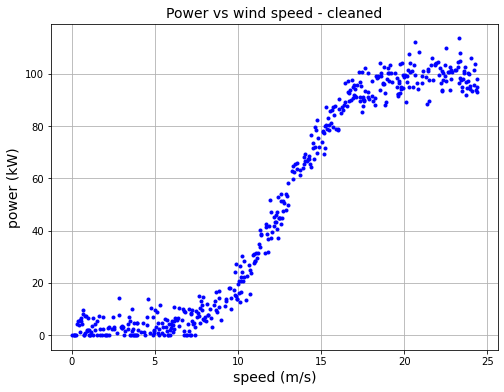

In [10]:
# Where do all the zeros occur?
dfz = df[df["power"] == 0]
# print(f'There are {dfz.shape} zero values for power')
# print(dfz)

# Want to keep all rows with power != 0 iff speed > 10
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
dfc = df.loc[(df.power == 0) & (df.speed > 10)] # indices where this is true
dfc # check 14 rows
# I want to remove these rows from my existing dataset.
df.drop(df.loc[(df.power == 0) & (df.speed > 10)].index, inplace=True)

plt.plot(df['speed'], df['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

## Identify promising models
<span style='color:red'> [1 Geron] </span> now suggests shortlisting promising models. I'll have to think about it. This is a supervised learning problem because we have been provided with a training set which is labeled: we know the power output for each value of input wind speed. Furthermore, it is a regression problem because we have been asked to predict a target numeric value of power given an input wind speed. This is different to classification, where one would be asked to predict what class a particular input belongs to; for example, using the iris data set predict iris species using some/all of the inputs petal length, petal width, sepal length, and sepal width. Some supervised learning algorithms suitable for our task include linear regression, neural networks, and maybe some like Support Vector Machine (SVM) regression and decision trees. I'll probably try the first two and only do more if I have time.

<span style='color:red'> [CourseML] </span> for some of these.

***
### Model 0: Linear Regression
Looking at the data, we could probably get away with fitting a straight line to it. That would likely do a very good job of predicting output power over a certain range of input wind speeds (around 10 - 15 m/s). However, it wouldn't do a great job around the places where the power is rising more slowly (< 10 m/s) or where it is leveling off (> 15 m/s). I think I'll start with a linear model and maybe move on to nonlinear regression afterwards. 

In [11]:
# Take a quick look at the correlation between the dataframe columns
df.corr()

,speed,power
speed,1.000000,0.950026
power,0.950026,1.000000


<span style='color:red'> [Medium nlr] </span> states that a correlation coefficient > 0.7 suggests a strong linear tendency and a nonlinear model would be inappropriate. We see values > 0.9 for the correlation between power and speed, so a straight line might actually be fine. We'll see.

(486, 1)
(486,)
Coefficients: 
 [5.5509909]
Mean squared error: 166.62
Coefficient of determination: 0.90


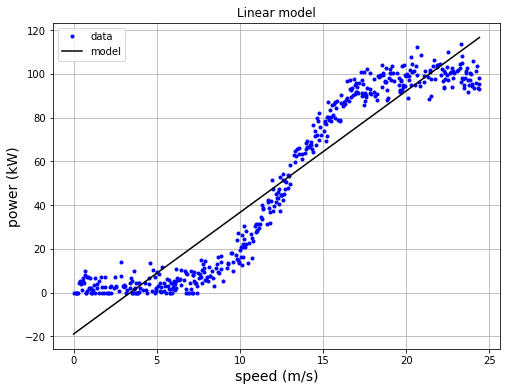

In [12]:
# From: https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares
# and example from
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

# Create linear regression object
reg = linear_model.LinearRegression()

# Need x and y in correct format TO DO restrict x values to be 7-18 & reflect that in front-end that calls model
X = df[["speed"]] # note dimensions
y = df["power"]

print(X.shape)
print(y.shape)

# Split into training and test sets TO DO LATER

# Train the model using the training sets
reg.fit(X, y)

# Make predictions using the testing set
y_pred = reg.predict(X)

# The coefficients
print('Coefficients: \n', reg.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

# Inspect the fit
plt.plot(df['speed'], df['power'],  '.b', label="data")
plt.plot(df['speed'], y_pred, 'k-', label="model")
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Linear model")
plt.grid()
plt.legend()

This is an example of *underfitting*, where the model is too simple to learn the structure of the data: a straight line is not a good fit to our data. One solution is to pick a more powerful model which has more parameters, so we will now try fitting a polynomial to our data. There are many possible nonlinear models <span style='color:red'> [5 Medium nlr] </span>. However, as we already know that $ power \propto speed^3$, a third order polynomial might be a good place to start.

First, I'll split the data set into a training and validation part (what we have been calling test) and look at the linear model as a function of training set size. The code that follows is taken directly from <span style='color:red'> [1 Geron] </span> (p. 132) with just some edits specific to this notebook. The plot below shows that the straight line is a good fit to the data (close to zero error) when there are only a few data points in the training set, but when more points are added to the training set, the error increases because a straight line is not a good fit to this data at all. The training error reaches a plateau. On the validation or test set, the model (having being trained on only a few training points) cannot generalize well at all to new data and the error is high. As more points are added to the training set, the model performs better and the validation error comes down, although it too tends towards the same limit. This learning curve is typical of a model that is underfitting. Adding more data will not help to bring down the error, but choosing a more complex model might <span style='color:red'> [6 CourseML] </span> (Week 6 lectures).

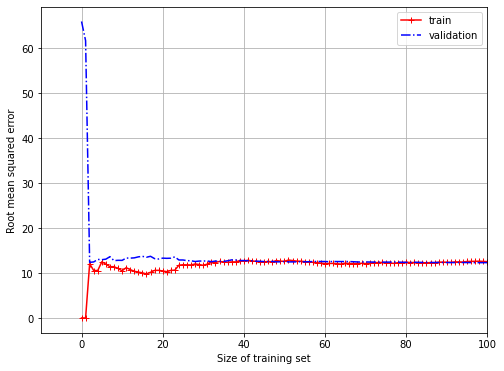

In [13]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", label="train")
    plt.plot(np.sqrt(val_errors), "b-.", label="validation")
    plt.legend()
    plt.xlabel("Size of training set")
    plt.ylabel("Root mean squared error")
    plt.grid()
    plt.xlim(-10, 100)

lin_reg = linear_model.LinearRegression()
plot_learning_curves(lin_reg, X, y)

***
### Model 1: Polynomial Regression

We transform our simple linear model $$y = \theta_0 + \theta_1 x $$ into a nonlinear one $$ y = \theta_0 + \theta_1 (x) + \theta_2 (x^2) + \theta_3 (x^3)$$ We can still do linear regression using this model because it is linear in the model parameters $\theta$: $\theta_0$ is the bias term (intercept in a straight line) and the remaining $\theta$ terms are feature weights. <span style='color:red'> [7 Medium polyReg] </span>. The $x$, $x^2$, and $x^3$ are our features, which we obtain by transforming the data we were given. We use the PolynomialFeatures class in Scikit-learn to do this by adding the square and cube of our data to create two new features <span style='color:red'> [1 Geron] </span> (p. 129). 

In [14]:
# Try polynomial order 3
poly_features = PolynomialFeatures(degree=3, include_bias=False) #include_bias -> intercept

# Split the data set into train/set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Generate the new features (powers of x) for the training data
X_train_poly = poly_features.fit_transform(X_train)

# Create an instance of the model & train it using the transformed training set.
regP = linear_model.LinearRegression()
regP.fit(X_train_poly, y_train)

# Prediction for y using test data?
X_test_poly = poly_features.fit_transform(X_test)
print(X_test_poly.shape)
y_predP = regP.predict(X_test_poly)

# The coefficients of the fit.
print(f'Coefficients: {regP.coef_}')
# Don't forget about the intercept - I did initially.
print(f'Intercept: {regP.intercept_:.2f}')

# The mean squared error
print(f'Mean squared error: {mean_squared_error(y_test, y_predP):.2f}')

# The coefficient of determination: 1 is perfect prediction
print(f'Coefficient of determination: {r2_score(y_test, y_predP):.2f}')

(98, 3)
Coefficients: [-9.73400228  1.49501894 -0.03951543]
Intercept: 14.24
Mean squared error: 36.09
Coefficient of determination: 0.98


In [15]:
# Predict power for a single input speed
xin = 20
out = regP.intercept_ + regP.coef_[0]*xin + regP.coef_[1]*(xin**2) + regP.coef_[2]*(xin**3)
print(f'For wind speed: {xin:.2f} polynomial regression predicts power  = {out:.2f}')

# Inspect the fit - seems to have a y shift of about -13 (I was forgetting y intercept!)
fit = regP.intercept_ + regP.coef_[0]*df['speed'] + regP.coef_[1]*(df['speed']**2) + regP.coef_[2]*(df['speed']**3)

For wind speed: 20.00 polynomial regression predicts power  = 101.45


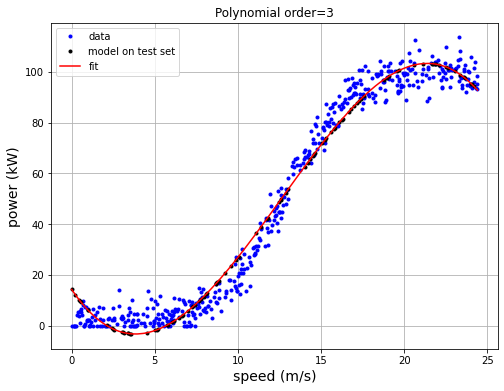

In [16]:
plt.plot(df['speed'], df['power'],  'b.', label="data")
plt.plot(X_test, y_predP, 'k.', label="model on test set")
plt.plot(df['speed'], fit, 'r-', label="fit")
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Polynomial order=3")
plt.grid()
plt.legend()

This looks like a reasonably food fit with an $R^2$ value very close to 1. Despite the high $R^2$ value, we can see that the fit is a little off as speed approaches 10 m/s and is greater than about 15 m/s. I'll definitely use it in my final product. I can't plot the test data as a line because the X_test values are randomly selected from the data set so they are not in ascending order - I get a scribble for a curve if I try. I might restrict input values of wind speed in the front end, for example,
- speed < 5, power = 0
- speed > 20, power = take an average of last 20 values in cleaned data set perhaps.

Our model for power output will be:
$$ power = 14.13 - 9.65 speed + 1.48 speed^2 - 0.04 speed^3$$

### Save the polynomial regression model 

In [17]:
joblib.dump(regP, "poly-reg.pkl")
print("Polynomial regression model saved as poly-reg.pkl")

Polynomial regression model saved as poly-reg.pkl


***
### Model 2: Support Vector Machines

I had come across the support vector machine (SVM) for detection of outliers and for logistic regression, where one is trying to do classification by finding a decision boundary which separates classes. SVM is a large margin classifier as it aims to find a decision boundary which has as large a margin as possible around the decision boundary, i.e, the margin does not contain any training data. SVM outputs a prediction (1 or 0) of whether or not an example belongs to a class, whereas logistic regression outputs a probability. Nonlinear decision boundaries can be tackled though choice of an appropriate kernal in the SVM - I'll explain later. I hadn't realised SVM could be used for regression, but Google tells me it can <span style='color:red'> [8 Medium SVRreg] </span>, so I'll give it a go. SVM regression works in the opposite way to what we have just described: the algorithm tries to fit as many training examples as possible inside the margin while limiting the number that fall outside it <span style='color:red'> [1 Geron] </span> (p. 162).

### SVM kernels
The documentation on SVM in Scikit-learn includes a good basic example of SVM regression performed using different kernels <span style='color:red'> [9 SVR, 10 SKLsvrKer] </span>. The function of the kernel is to transform the input data into the form required for a particular problem <span style='color:red'> [11 DFkernel] </span>. For example, if the decision boundary between two classes is not a simple straight line, one could try using a nonlinear kernel (like polynomial) to better fit the boundary between the classes. As I understand it, this is equivalent to transforming an input feature $x$ to generate polynomial features $x^2, x^3, ..$ as we did above in model 2. It is advisable to try a linear kernel first and then move to the Gaussian radial basis function (RBF) <span style='color:red'> [1 Geron] </span> (p. 161), a good general purpose kernel when there is no prior knowledge about the data <span style='color:red'> [11 DFkernel] </span>. The idea of this type of kernel is to compute new features based on the proximity of training examples to landmarks (their similarity), and the simplest thing to do is chose the landmarks to be the training examples themselves <span style='color:red'> [6 CourseML] </span> (Week 7). The Scikit-learn SVM regression algorithm must do this automatically. I'll play around with the various parameters to find a good fit to our data set.

Another thing I see mentioned a lot is that SVMs are sensitive to scaling, so we'll probably have to apply some type of transformation to our input feature before training a model <span style='color:red'> [12 MLMscaler] </span>. 

I will try a linear kernel first and see how we get on. The parameter C is related to regularization, with default value = 1. Regularization is used to constrain a model to make it more simple, and thus avoiding overfitting. The amount of regularization is usually controlled by a parameter in the machine learning model. Here, small C means lots of regularization, which implies high bias and low variance, or a model that's too simple. Large C means very little regularization, which translates to overfitting as a result of low bias and high variance. I think, regardless of what C I pick below, a linear model will never fit the data which is clearly nonlinear.

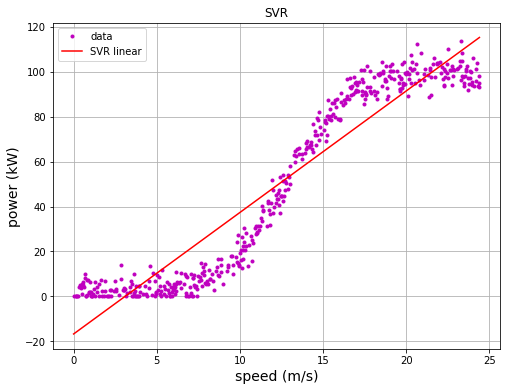

In [18]:
# Create an instance of the SVR class
# C ~1/reg default = 1. Tiny C bad fit, Huge C over fit
svr_lin = SVR(kernel='linear', C=1)

# Scale X only
sc_X = StandardScaler()
X_scale = sc_X.fit_transform(X)

# Train model with scaled X and y
svr_lin.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_lin.predict(X_scale), '-r', label="SVR linear") # prediction using scaled X data
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("SVR")
plt.grid()
plt.legend()

This linear kernel produces much the same result as when we tried simple linear regression above. Lets try a polynomial kernel with degree = 3 as we know the power out has $v^3$ component. Feature x is already scaled from above. coeff0 is the independent term in the kernel function with default value 0. I got a very bad prediction with coef0=0 and found that coef0=1 worked well. Making it even bigger didn't appear to do much to the fit but it took the code a tiny bit longer to run. <span style='color:red'> [13 SVRpractical] </span> gives some explanation of the parameters - gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected. I'll leave it at the default value, and same for epsilon. I'll leave the regularization parameter C = 1. If I change C to be 0.1 or something small I end up with an almost linear prediction - so lots of regularization which translates into a too simple model. 

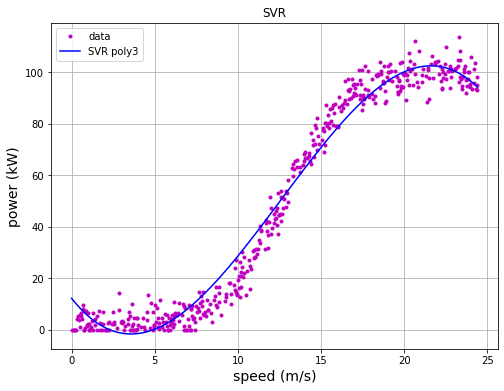

In [19]:
# Create an instance of the SVR class
svr_ply = SVR(kernel="poly", degree=3, coef0=1, C=1, epsilon=0.1, gamma='auto') # OK like poly LR
# coef0 is ..
# epsilon is ..

# Train model with scaled X and y
svr_ply.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_ply.predict(X_scale), '-b', label="SVR poly3") # prediction using scaled X data
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("SVR")
plt.grid()
plt.legend()

Lastly, I'll try the RBF kernel and I'll play around with C. I found that C = 0.1 gives a very bad fit, and as C approaches 1 the fit gets better. I'll end up leaving it at the default of 1. 

In [20]:
#Few C values to try.
c_vals = [0.1, 0.2, 0.5, 1, 5, 10]
r2 = []
for c in c_vals:
    svr_c = SVR(kernel="rbf", C=c, gamma='auto')
    svr_c.fit(X_scale, y)
    svr_c.predict(X_scale)
    r2.append(svr_c.score(X_scale, y))
    print(f'C = {c}, R-squared = {svr_c.score(X_scale, y):.4f}')

C = 0.1, R-squared = 0.5288
C = 0.2, R-squared = 0.8592
C = 0.5, R-squared = 0.9785
C = 1, R-squared = 0.9860
C = 5, R-squared = 0.9898
C = 10, R-squared = 0.9901


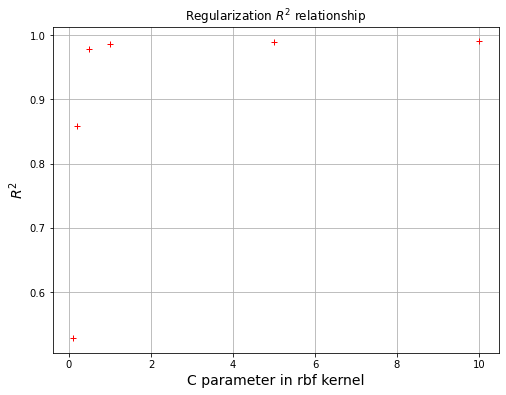

In [21]:
plt.plot(c_vals, r2, 'r+')
plt.xlabel('C parameter in rbf kernel', fontsize='14')
plt.ylabel('$R^2$', fontsize='14')
plt.title("Regularization $R^2$ relationship")
plt.grid()

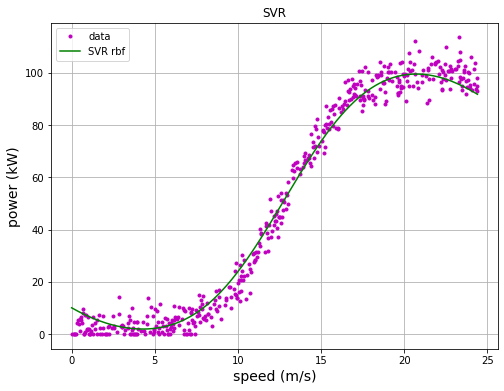

In [22]:
# Create an instance of the SVR class
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto')

# Train model with scaled X and y
svr_rbf.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_rbf.predict(X_scale), '-g', label="SVR rbf") # prediction using scaled X data
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("SVR")
plt.grid()
plt.legend()

I think this is doing a slightly better job than polynomial SVM regression. Finally, I'll split the data set into a train / test part and evaluate the model on test data.

R-squared on test data = 0.9864


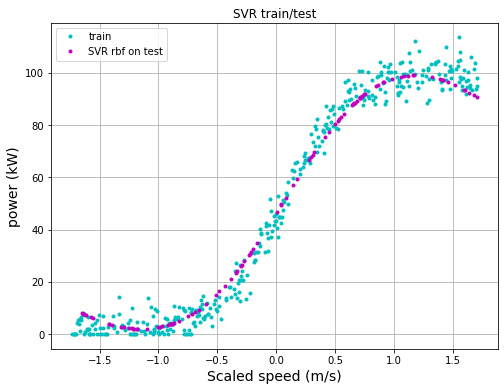

In [23]:
# Split the data set into train/set.  X already scaled but y is not
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.2)

# Create an instance of the SVR class
svr_final = SVR(kernel="rbf", C=1, gamma='auto')

# Train model with training data scaled X and y.
svr_final.fit(X_train, y_train)

# Test it on test data.
y_pred = svr_final.predict(X_test)

# And plot.
plt.plot(X_train, y_train, '.c', label="train") # X, y training data
plt.plot(X_test, y_pred, '.m', label="SVR rbf on test") # prediction using scaled X_test data
plt.xlabel('Scaled speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("SVR train/test")
plt.grid()
plt.legend()

# R-squared.
print(f'R-squared on test data = {svr_final.score(X_test, y_test):.4f}')

Note that the scaled speed is displayed on this plot. In order to make a prediction of power given wind speed, I'll have to apply the same scaling transform to the input speed before using the predict method.

In [24]:
# Q. How to predict from a single value? A. Need x and the transformer sc_X
# Scaling issue? As predictions for -1,0,1 seems to match power.
print(f'wind = 1, power = {svr_final.predict([[1]])}')

# Apply same scaler to the x value we want to test.
xin = [[15]]
xin_scale = sc_X.transform(xin)

# Make a prediction for this scaled value - seems sensible.
yout = svr_final.predict(xin_scale)
print(f'wind = {xin[0][0]}, power = {yout[0]}')

wind = 1, power = [97.88052108]
wind = 15, power = 73.3172777044485


### Save the support vector machine regression model

In [25]:
joblib.dump(svr_final, "svm-reg.pkl")
print("Support vector machine regression model saved as svm-reg.pkl")

Support vector machine regression model saved as svm-reg.pkl


***
### Model 3: Neural Network

Both polynomial and SVM regression are doing a reasonably good job of predicting power given wind speed. I think the SVM regression model with rbf kernel does best, but if you look closely, you can still see that the fit (prediction) doesn't always go through the data in a symmetric way. For example, in the last plot above you can see that the prediction is a tiny bit off for scaled speed in the range -1 to 0. I'm now going to investigate if a neural network will do a better job.

An artificial neural network, or just a neural network, is a machine learning model inspired by the networks of biological neurons found in human brains <span style='color:red'> [14 WikiANN] </span>. Each individual biological neuron is relatively simple, but because each one is connected to many thousands of others, they can perform complicated tasks when working together. With that idea replicated for machine learning, the idea of a an artificial neuron is that its output fires depending on the value of the inputs to it. This is what a *threshold logic unit* is based on: the output of such a unit is the weighted sum of its inputs multiplied by an step function, which acts like an on/off switch. A *perceptron* is a single layer of these units where each unit is connected to all the inputs. If each neuron in a layer is connected to all the neurons in a previous layer, that layer is a *dense* layer. A *bias* is also fed to each unit - I think of it like the intercept in a straight line as it allows one to apply a constant shift to the step function (or activation function in general terms).  Finally, A *multilayer perceptron* (MLP) is obtained by stacking multiple perceptrons. A MLP has a single input layer, one or more hidden layers, and a final output layer. This quick run thorough the terminology is based on Chapter 10 of <span style='color:red'> [1 Geron] </span>. I know this explanation is not necessary but I'm interested in it and don't mind spending a little time on it. For this project, we will use the Keras API to build and train our neural networks, with the heavy computation associated with neural networks done in a backend called TensorFlow [<span style='color:red'> [15 keras, 16 tf] </span>]. We can easily build a MLP model in Keras by stacking neural network layers sequentially. An image of such a neural network is shown below <span style='color:red'> [17 mediumANN] </span>. For neural networks with many hidden layers, each containing many neurons, the number of connections can be huge. The sizes of the weights matrices below reflect this: for example $W_1$ has size 4x5 because there are 5 neurons in hidden layer 1, each connected to four inputs.

<img src="img/ANN.png" height=400 width=400>

In [26]:
# Refresh our memory re. the data - looks good.
#plt.plot(df['speed'], df['power'],  '.g')
#plt.plot(X, y,  '-r')

# Split the data set into train/set. (not yet using)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Take some of the training set to be a validation set. 
# Want train:test:validation = 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(291, 1)
(291,)
(98, 1)
(98,)
(97, 1)
(97,)


Now we construct a neural network consisting of three layers: the input layer, a hidden layer with 50 neurons, and the output layer. The size of the input and output layers is determined by the data we have and what we want to predict. Having one hidden layer is a good default, but if there are more hidden layers, it's recommended to have the same number of neurons in each hidden layer <span style='color:red'> [6 CourseML] </span> (week 5). The more neurons there are in each hidden layer the better, but this must be balanced against increased computation time for more neurons. 

The steps involved in building such a neural network are outlined nicely here <span style='color:red'> [18 NNWhowto] </span> with a good explanation of sizes etc here <span style='color:red'> [19 SOkerasIP] </span>. 
- We have one hidden layer with 50 neurons and it's a dense layer. 
- The input to it is a one-dimensional tensor (like a matrix). 
- The method of initialization for the weights and biases is also chosen here. It's important that the weights are not all set to zero initially (kernel_initializer parameter). I'll explain this a little later.
- The activation function is a sigmoid, like a smoothed out step function that we mentioned above. The fact that it's smooth means it has a derivative, which is important when it comes to calculating loss etc in a while.
- Our output layer has just one neuron and the activation function is linear so that the output can have any range of values.

In [27]:
# Create a Sequential model incrementally via the add() method:
# kernel_initializer="glorot_uniform"
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

Once the model is designed, we must compile it to specify the *learning rate* and *loss function*, the quantity we are trying to minimize in through training of the network. 

In [28]:
# Compile the model and summarize it.
model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


The hidden layer has 50 neurons plus 50 bias terms giving 100 parameters for this layer. The output layer has 1 neuron with one bias term and 50 inputs feeding to it, so 51 parameters in total. The network has 151 parameters. The aim is to train it and find *good* values for these 151 parameters. How is this training done? 

**Backpropagation**

The algorithm used is called backpropagation, and consists of two passes through the network, one in the forward direction and one backward. Each training example (or batch of them) is passed through the each layer to the output, with the output of each layer being calculated at each stage. This is the forward pass. The output error is then calculated in the form of a loss function. The algorithm then goes through each layer in reverse, calculating how much of the error is contributed by each connection. The weights are then adjusted to reduce the error. In the backward pass the error gradient is propagated back through the network, and gradient descent is used to move in the direction of decreasing error in parameter space. The learning rate controls the step size in gradient descent.

The sigmoid activation function is used because it has a gradient (unlike the step function) and so gradient descent can work. It is important that all weights are not initialized to zero (kernel_initializer model parameter above) because we want to break symmetry in the network: if all neurons had the same weight then backpropagation would see no difference between them and training would fail. Stochastic gradient descent (SGD) is kind of the default method used to minimize the loss function, but it requires more tuning of the learning rate. The Adam optimizer (extended from SGD) we have used above is an adaptive algorithm (in that it can change the learning rate during training) so we don't need to worry about setting it, just use the default value. Glorot initialization of weights is a technique to ensure that gradients neither vanish nor explode during backpropogation <span style='color:red'> [1 Geron p. 357, 333] </span>. 

If we apply the predict method to our input X at this stage, using initialized values of biases and weights, we are performing forward propagation of our inputs through an untrained neural network. The network has not learned anything and shouldn't be able to make a sensible prediction yet.

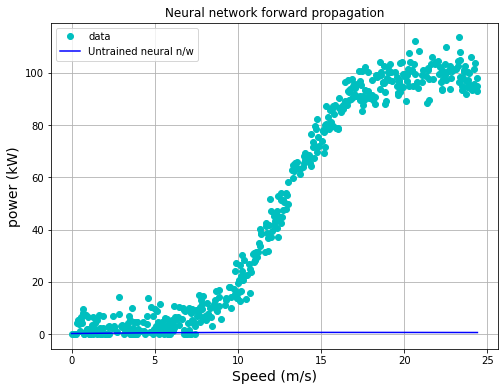

In [29]:
# Look at output with no training.
plt.plot(X, y, 'co', label="data")
plt.plot(X, model.predict(X), 'b-', label="Untrained neural n/w")
plt.xlabel('Speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Neural network forward propagation")
plt.legend()
plt.grid()

Now we train the network over 500 epochs - like number of iterations. We can speed up the training by doing so in batches. The parameter batch_size is the number of samples per gradient update. Gradient descent (or a variant of it) is an algorithm used to minimize the cost function at each epoch. Normal gradient descent involves all samples in the training set being used to calculate the gradient and cost function; it proceeds smoothly towards a minimum of the cost function in parameter space. SGD calculates the gradient and cost for each each epoch using one sample (randomly selected hence stochastic); it proceeds in a jagged way towards a minimum but it does so faster. Mini-batch SGD uses a small random subset of the training examples at each iteration, so it's somewhere in between gradient descent and SGD <span style='color:red'> [6 CourseML (week 10), x GDvsSGD] </span>. 

In [30]:
# Train the network using the training data.
# Keep track of loss for validation data too - not being used in training.
# Could do history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_data=(X_val, y_val))
model.fit(X_train, y_train, epochs=500, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/500
30/30 [==============================] - 0s 7ms/step - loss: 3952.5667 - val_loss: 4363.8154
Epoch 2/500
30/30 [==============================] - 0s 1ms/step - loss: 3851.5344 - val_loss: 4248.2173
Epoch 3/500
30/30 [==============================] - 0s 1ms/step - loss: 3746.9531 - val_loss: 4122.4380
Epoch 4/500
30/30 [==============================] - 0s 2ms/step - loss: 3633.9382 - val_loss: 3992.3850
Epoch 5/500
30/30 [==============================] - 0s 2ms/step - loss: 3516.9075 - val_loss: 3847.3420
Epoch 6/500
30/30 [==============================] - 0s 1ms/step - loss: 3380.1545 - val_loss: 3686.2588
Epoch 7/500
30/30 [==============================] - 0s 1ms/step - loss: 3246.0557 - val_loss: 3537.9155
Epoch 8/500
30/30 [==============================] - 0s 2ms/step - loss: 3129.6897 - val_loss: 3423.1636
Epoch 9/500
30/30 [==============================] - 0s 2ms/step - loss: 3035.7161 - val_loss: 3317.8022
Epoch 10/500
30/30 [==============================] - 0

Epoch 78/500
30/30 [==============================] - 0s 1ms/step - loss: 629.9993 - val_loss: 643.7997
Epoch 79/500
30/30 [==============================] - 0s 1ms/step - loss: 615.5993 - val_loss: 627.1385
Epoch 80/500
30/30 [==============================] - 0s 1ms/step - loss: 601.1567 - val_loss: 612.5013
Epoch 81/500
30/30 [==============================] - 0s 1ms/step - loss: 587.8127 - val_loss: 598.5310
Epoch 82/500
30/30 [==============================] - 0s 1ms/step - loss: 575.6727 - val_loss: 586.4557
Epoch 83/500
30/30 [==============================] - 0s 1ms/step - loss: 561.5877 - val_loss: 570.3225
Epoch 84/500
30/30 [==============================] - 0s 1ms/step - loss: 550.2225 - val_loss: 557.0301
Epoch 85/500
30/30 [==============================] - 0s 1ms/step - loss: 536.6845 - val_loss: 545.2086
Epoch 86/500
30/30 [==============================] - 0s 1ms/step - loss: 524.1185 - val_loss: 530.0533
Epoch 87/500
30/30 [==============================] - 0s 1ms/ste

30/30 [==============================] - 0s 1ms/step - loss: 130.4722 - val_loss: 126.0319
Epoch 156/500
30/30 [==============================] - 0s 1ms/step - loss: 129.5098 - val_loss: 124.2301
Epoch 157/500
30/30 [==============================] - 0s 1ms/step - loss: 126.4072 - val_loss: 122.1590
Epoch 158/500
30/30 [==============================] - 0s 2ms/step - loss: 125.0160 - val_loss: 120.1255
Epoch 159/500
30/30 [==============================] - 0s 1ms/step - loss: 122.6397 - val_loss: 118.2764
Epoch 160/500
30/30 [==============================] - 0s 1ms/step - loss: 120.8608 - val_loss: 116.6196
Epoch 161/500
30/30 [==============================] - 0s 1ms/step - loss: 119.7678 - val_loss: 114.9535
Epoch 162/500
30/30 [==============================] - 0s 2ms/step - loss: 118.2520 - val_loss: 113.2350
Epoch 163/500
30/30 [==============================] - 0s 2ms/step - loss: 115.6340 - val_loss: 111.5375
Epoch 164/500
30/30 [==============================] - 0s 1ms/step - 

30/30 [==============================] - 0s 2ms/step - loss: 53.9011 - val_loss: 55.7531
Epoch 235/500
30/30 [==============================] - 0s 2ms/step - loss: 53.3477 - val_loss: 55.3891
Epoch 236/500
30/30 [==============================] - 0s 2ms/step - loss: 53.0467 - val_loss: 55.0566
Epoch 237/500
30/30 [==============================] - ETA: 0s - loss: 44.79 - 0s 1ms/step - loss: 52.5815 - val_loss: 54.6317
Epoch 238/500
30/30 [==============================] - 0s 1ms/step - loss: 52.2739 - val_loss: 54.3226
Epoch 239/500
30/30 [==============================] - 0s 1ms/step - loss: 52.0480 - val_loss: 53.9581
Epoch 240/500
30/30 [==============================] - 0s 1ms/step - loss: 51.1885 - val_loss: 53.6622
Epoch 241/500
30/30 [==============================] - 0s 1ms/step - loss: 50.9841 - val_loss: 53.3138
Epoch 242/500
30/30 [==============================] - 0s 1ms/step - loss: 50.4928 - val_loss: 52.9755
Epoch 243/500
30/30 [==============================] - 0s 1ms/s

30/30 [==============================] - 0s 1ms/step - loss: 32.3081 - val_loss: 35.8049
Epoch 314/500
30/30 [==============================] - ETA: 0s - loss: 24.37 - 0s 1ms/step - loss: 32.2243 - val_loss: 35.4637
Epoch 315/500
30/30 [==============================] - 0s 1ms/step - loss: 31.9256 - val_loss: 35.2128
Epoch 316/500
30/30 [==============================] - 0s 1ms/step - loss: 31.6422 - val_loss: 35.0376
Epoch 317/500
30/30 [==============================] - 0s 1ms/step - loss: 31.5196 - val_loss: 34.8654
Epoch 318/500
30/30 [==============================] - 0s 2ms/step - loss: 31.7793 - val_loss: 34.7641
Epoch 319/500
30/30 [==============================] - 0s 2ms/step - loss: 31.9488 - val_loss: 34.5346
Epoch 320/500
30/30 [==============================] - 0s 1ms/step - loss: 31.4190 - val_loss: 34.3361
Epoch 321/500
30/30 [==============================] - 0s 1ms/step - loss: 30.9323 - val_loss: 34.2060
Epoch 322/500
30/30 [==============================] - 0s 1ms/s

30/30 [==============================] - 0s 2ms/step - loss: 23.5555 - val_loss: 26.2616
Epoch 393/500
30/30 [==============================] - 0s 2ms/step - loss: 23.4471 - val_loss: 26.2304
Epoch 394/500
30/30 [==============================] - 0s 2ms/step - loss: 23.0917 - val_loss: 26.4382
Epoch 395/500
30/30 [==============================] - 0s 1ms/step - loss: 23.0227 - val_loss: 26.0106
Epoch 396/500
30/30 [==============================] - 0s 2ms/step - loss: 22.9292 - val_loss: 26.3662
Epoch 397/500
30/30 [==============================] - 0s 2ms/step - loss: 23.1660 - val_loss: 26.1222
Epoch 398/500
30/30 [==============================] - 0s 2ms/step - loss: 22.9880 - val_loss: 25.8319
Epoch 399/500
30/30 [==============================] - 0s 1ms/step - loss: 23.0883 - val_loss: 25.8434
Epoch 400/500
30/30 [==============================] - 0s 1ms/step - loss: 22.6527 - val_loss: 25.9250
Epoch 401/500
30/30 [==============================] - 0s 2ms/step - loss: 22.6949 - va

30/30 [==============================] - 0s 1ms/step - loss: 19.8404 - val_loss: 22.5010
Epoch 472/500
30/30 [==============================] - 0s 1ms/step - loss: 19.8146 - val_loss: 22.4420
Epoch 473/500
30/30 [==============================] - 0s 1ms/step - loss: 19.8214 - val_loss: 22.5917
Epoch 474/500
30/30 [==============================] - 0s 1ms/step - loss: 19.7357 - val_loss: 22.4644
Epoch 475/500
30/30 [==============================] - 0s 1ms/step - loss: 19.7166 - val_loss: 22.8050
Epoch 476/500
30/30 [==============================] - 0s 1ms/step - loss: 19.6195 - val_loss: 22.4949
Epoch 477/500
30/30 [==============================] - 0s 1ms/step - loss: 19.7282 - val_loss: 22.4166
Epoch 478/500
30/30 [==============================] - 0s 1ms/step - loss: 19.6250 - val_loss: 22.5641
Epoch 479/500
30/30 [==============================] - 0s 1ms/step - loss: 19.5359 - val_loss: 22.6555
Epoch 480/500
30/30 [==============================] - 0s 1ms/step - loss: 19.5389 - va

Ideally, the loss calculated from the training data should be close to that calculated using the validation data (which was not used in training the model). If they differ significantly, that's a sign that something is up. Some parameters may need to be changed. If the validation error is still reducing, the model hasn't converged yet and one can continue training by just running the above cell again. I hadn't fully appreciated the difference between the train/test data and the validation data, but I see it now: the training data is used to train the model, the validation data is used to measure loss during model training to see if there are problems like under or overfitting. If there are, parameters can be changed and the model re-trained. Finally, after training and tuning of parameters, the test data is used to make predictions. It has had no input to the model training.

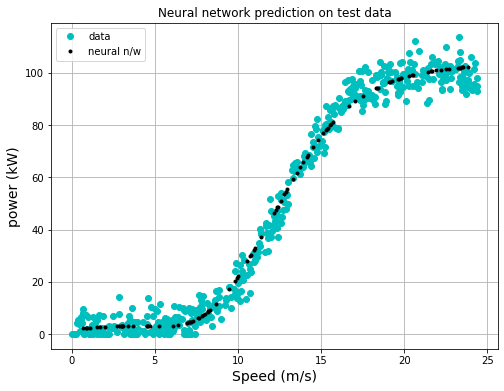

In [31]:
# Look at prediction for the test data - was not used in training.
plt.plot(X, y, 'co', label="data")
plt.plot(X_test, model.predict(X_test), 'k.', label="neural n/w")
plt.xlabel('Speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Neural network prediction on test data")
plt.grid()
plt.legend()

This is doing an excellent job, and to be honest, it seems like magic to me. Without knowing a thing about the data - why it looks like it does - we can make predictions. I'm more used to knowing what a quantity should look like in theory, and then fitting experimental data to that theory in order to measure error. 

In [32]:
# Predict from a single input value - seems sensible.
wind = [[23]]
print(model.predict(wind))

[[101.81816]]


### Save this neural network model

In [33]:
model.save("neural-nw.h5")
print("Neural network model saved as neural-nw.h5")

Neural network model saved as neural-nw.h5


## References
<span style='color:red'> [1 Geron] </span> Aurelien Geron, *Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow*, **2019**, 2nd Edition, O'Reilly Media, Inc., CA

<span style='color:red'> [2 np random] </span> numpy.random.rayleigh, NumPy v1.19 Manual, https://numpy.org/doc/stable/reference/random/generated/numpy.random.rayleigh.html

<span style='color:red'> [3 WT curve] </span> Wind Energy Basics, New York Wind Energy Guide for Local Decision Makers, www.nyserda.ny.gov/-/media/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, (Accessed 9 Nov. 2020).

<span style='color:red'> [4 WT calc] </span> Wind Turbine Power Calculations, RWE npower renewables, https://docplayer.net/17802133-Wind-turbine-power-calculations.html, (Accessed 21 Oct. 2020).

<span style='color:red'> [5 Medium nlr] </span> Medium.com, Understanding Non-Linear Regression, https://medium.com/towards-artificial-intelligence/understanding-non-linear-regression-fbef9a396b71 (Accessed 1 Dec. 2020).

<span style='color:red'> [6 CourseML] </span> Andrew Ng, Coursera Machine Learning offered by Stanford, https://www.coursera.org/learn/machine-learning, (Completed & certified Sept. 2020).

<span style='color:red'> [7 Medium polyReg] </span> Medium.com, Polynomial Regression, https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 (Accessed 7 Dec. 2020).

<span style='color:red'> [8 Medium SVRreg] </span> Medium.com, Support Vector Regression in 6 Steps with Python, https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d (Accessed 9 Dec. 2020).

<span style='color:red'> [9 SVR] </span> Scikit-learn, 1.4. Support Vector Machines, https://scikit-learn.org/stable/modules/svm.html#regression (Accessed 12 Dec. 2020).

<span style='color:red'> [10 SKLsvrKer] </span> Scikit-learn, Support Vector Regression (SVR) using linear and non-linear kernels, https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_regression.html (Accessed 12 Dec. 2020).

<span style='color:red'> [11 DFkernel] </span> Data Flair, Kernel Functions-Introduction to SVM Kernel & Examples, https://data-flair.training/blogs/svm-kernel-functions/#:~:text=SVM%20Kernel%20Functions&text=The%20function%20of%20kernel%20is,(RBF)%2C%20and%20sigmoid. (Accessed 12 Dec. 2020).

<span style='color:red'> [12 MLMscaler] </span> Machine Learning Mastery, How to Use StandardScaler and MinMaxScaler Transforms in Python, https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/ (Accessed 12 Dec. 2020).

<span style='color:red'> [13 SVRpractical] </span> Scikit-learn, 1.4.5. Tips on Practical Use, https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use (Accessed 12 Dec. 2020).

<span style='color:red'> [14 WikiANN] </span> Wikipedia, Artificial neural network, https://en.wikipedia.org/wiki/Artificial_neural_network (Accessed 16 Dec. 2020).

<span style='color:red'> [15 keras] </span> Keras, Introduction to Keras for Engineers, https://keras.io/getting_started/intro_to_keras_for_engineers/ (Accessed 16 Dec. 2020).

<span style='color:red'> [16 tf] </span> TensorFlow, https://www.tensorflow.org/ (Accessed 16 Dec. 2020).

<span style='color:red'> [17 mediumANN] </span> Medium.com, The Artificial Neural Networks handbook: Part 1, https://medium.com/coinmonks/the-artificial-neural-networks-handbook-part-1-f9ceb0e376b4 (Accessed 17 Dec. 2020).

<span style='color:red'> [18 NNWhowto] </span> Machine Learning Mastery, How To Build Multi-Layer Perceptron Neural Network Models with Keras, https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/ (Accessed 16 Dec. 2020).

<span style='color:red'> [19 SOkerasIP] </span> Stack Overflow, Keras input explanation: input_shape, units, batch_size, dim, etc, https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc (Accessed 17 Dec. 2020).

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/ BASIC pickle

https://machinelearningmastery.com/how-to-save-and-load-models-and-data-preparation-in-scikit-learn-for-later-use/ scaler

https://machinelearningmastery.com/save-load-keras-deep-learning-models/ GOOD


https://srnghn.medium.com/machine-learning-trying-to-predict-a-numerical-value-8aafb9ad4d36

https://stackoverflow.blog/2020/10/12/how-to-put-machine-learning-models-into-production/

https://towardsdatascience.com/simple-way-to-deploy-machine-learning-models-to-cloud-fd58b771fdcf

Consulted:
***
<span style='color:red'> [WT FAQ] </span> Wind Turbine FAQ, ENERPOWER Total Energy Solutions, https://enerpower.ie/portfolio/wind-turbine-faq-ireland/, (Accessed 21 Oct. 2020).

<span style='color:red'> [MLM select] </span> Machine Learning Mastery, A Gentle Introduction to Model Selection for Machine Learning, https://machinelearningmastery.com/a-gentle-introduction-to-model-selection-for-machine-learning/ (Accessed 30 Nov. 2020)

<span style='color:red'> [x GDvsSGD] </span> Stack Exchange, What is the difference between Gradient Descent and Stochastic Gradient Descent?, https://datascience.stackexchange.com/questions/36450/what-is-the-difference-between-gradient-descent-and-stochastic-gradient-descent#:~:text=In%20Gradient%20Descent%20or%20Batch,of%20training%20data%20per%20epoch (Accessed 16 Dec. 2020).

To do:
- saving models
- restoring models
- saving scalers
- saving poly features transform if need be.

<br>

### End